Author: Xiaoyi Huang  
xiaoyihuang92@gmail.com  

# Seattle Airbnb Data Analysis 

In this notebook, I'm going to find out the factors highly influence the price. 

In [1]:
# import commonly used packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
listings = pd.read_csv('https://raw.githubusercontent.com/XHuang2046/Seattle_Airbnb/main/Data/listings.csv')

In [3]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

### Data Exploration and Cleaning

In [7]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,...,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,...,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,...,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.629724,-122.369483,t,House,Entire home/apt,...,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$975.00,NaN,NaN,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,t,1,6,17,220,20,2014-07-30,2015-09-03,97

In [16]:
# create a copy of dataframe after each cleaning action, thus we can retreive the dataframe if neccessary
df_copy = listings.copy()

# Create a data cleaning log
data_clean_log = pd.DataFrame({
                         'action':'Start', 
                         'nrow_after': listings.shape[0],
                         'ncol_after': listings.shape[1]}, index = [0])
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818,92


#### **1) Remove unrelated features**

In [17]:
# Remove features containing url. They're created while scraping the data and are unrelated to the price.
all_cols = listings.columns.to_list()
drop_col = []
for col in all_cols:
  if 'url' in col:
    drop_col.append(col)
  else:
    pass
drop_col

['listing_url',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url']

In [18]:
listings.drop(columns=drop_col,inplace=True)
listings.shape

(3818, 84)

In [19]:
# Remove other useless features created while scraping.
listings.drop(columns=['scrape_id','last_scraped','calendar_last_scraped'],inplace=True)
listings.shape

(3818, 81)

In [20]:
df_copy = listings.copy()

data_clean_log.at[1,['action','nrow_after','ncol_after']] = ['Remove unrelated features',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0


#### **2) Examine and remove features with more than 40% missing**

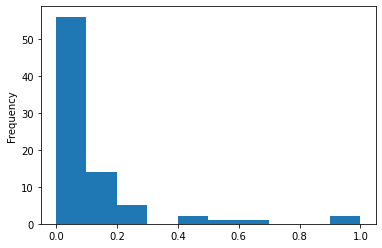

In [21]:
null_ratio = listings.isnull().mean().sort_values(ascending=False)
null_ratio.plot(kind ='hist');
# More than 50 features don't have null value.

In [22]:
null_ratio[null_ratio>0.4]

license             1.000000
square_feet         0.974594
monthly_price       0.602672
security_deposit    0.511262
weekly_price        0.473808
notes               0.420639
dtype: float64

In [23]:
listings.notes.head()
# Words info, hard to process, with too many NAN. 
# Remove notes

0                                                  NaN
1    What's up with the free pillows?  Our home was...
2    Our house is located just 5 short blocks to To...
3                                                  NaN
4                                            Belltown 
Name: notes, dtype: object

In [24]:
# Drop notes
listings.drop(columns=['notes'], inplace=True)

# Drop the license column, since it contains only NAN.
# Drop the square_feet column, since it contains too many NAN value.
listings.drop(columns=['license','square_feet'], inplace=True)

# Monthly_price is price with Length-of-stay discounts, so is weekly_price. So these two factors are affected by price not the factors affecting the price. 
# Thus, we can remove them.
listings.drop(columns=['monthly_price','weekly_price'], inplace=True)

# Airbnb calculates the security deposit amount according to 60% of a listing’s nightly rate (this amount adjusts for longer stays). 
# A factor affected by the nightly rate. So we remove it.
listings.drop(columns=['security_deposit'], inplace=True)

In [25]:
df_copy = listings.copy()

data_clean_log.at[2,['action','nrow_after','ncol_after']] = ['Drop features with more than 40% of NAN',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0


#### **3) Drop features with low variability**

In [26]:
#indentifies features with no variance, which are none informative to analysis.
no_variance = []
for col in listings.columns:
    freq = listings[col].value_counts().index.unique()
    if len(freq)==1:
        print([col, freq])
        no_variance.append(col)

['experiences_offered', Index(['none'], dtype='object')]
['market', Index(['Seattle'], dtype='object')]
['country_code', Index(['US'], dtype='object')]
['country', Index(['United States'], dtype='object')]
['has_availability', Index(['t'], dtype='object')]
['requires_license', Index(['f'], dtype='object')]
['jurisdiction_names', Index(['WASHINGTON'], dtype='object')]


In [27]:
listings.drop(labels = no_variance, axis = 1,inplace=True)

In [28]:
low_variance = []
for col in listings.columns:
    freq = listings[col].value_counts().index.unique()
    if len(freq)==2:
        print([col, freq])
        low_variance.append(col)

['host_acceptance_rate', Index(['100%', '0%'], dtype='object')]
['host_is_superhost', Index(['f', 't'], dtype='object')]
['host_has_profile_pic', Index(['t', 'f'], dtype='object')]
['host_identity_verified', Index(['t', 'f'], dtype='object')]
['state', Index(['WA', 'wa'], dtype='object')]
['is_location_exact', Index(['t', 'f'], dtype='object')]
['instant_bookable', Index(['f', 't'], dtype='object')]
['require_guest_profile_picture', Index(['f', 't'], dtype='object')]
['require_guest_phone_verification', Index(['f', 't'], dtype='object')]


In [29]:
for col in low_variance:
  print(listings[col].value_counts())

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64
f    3038
t     778
Name: host_is_superhost, dtype: int64
t    3809
f       7
Name: host_has_profile_pic, dtype: int64
t    2997
f     819
Name: host_identity_verified, dtype: int64
WA    3817
wa       1
Name: state, dtype: int64
t    3412
f     406
Name: is_location_exact, dtype: int64
f    3227
t     591
Name: instant_bookable, dtype: int64
f    3497
t     321
Name: require_guest_profile_picture, dtype: int64
f    3443
t     375
Name: require_guest_phone_verification, dtype: int64


In [30]:
# host_acceptance_rate, host_has_profile_pic and state have low variability
# we can remove them
listings.drop(columns = ['host_acceptance_rate','host_has_profile_pic','state'],inplace=True)

In [31]:
df_copy = listings

# Update the data clean log

data_clean_log.at[3,['action','nrow_after','ncol_after']] = ['Drop features with low variability',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0
3,Drop features with low variability,3818.0,65.0


#### **4) Drop text features that are hard to use in quantitative models**

In [32]:
listings.city.value_counts() # Not useful

Seattle                  3810
Seattle                     2
West Seattle                2
西雅图                         1
Phinney Ridge Seattle       1
Ballard, Seattle            1
seattle                     1
Name: city, dtype: int64

In [33]:
listings.smart_location.value_counts() # Not useful

Seattle, WA                  3810
Seattle , WA                    2
West Seattle, WA                2
seattle, wa                     1
西雅图, WA                         1
Phinney Ridge Seattle, WA       1
Ballard, Seattle, WA            1
Name: smart_location, dtype: int64

In [34]:
listings.bed_type.value_counts() # Seems useful

Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64

In [35]:
text_cols = ['name','summary','space','description','neighborhood_overview','transit','host_name','host_location','host_about','host_verifications','street','city','zipcode',
             'smart_location']

In [36]:
listings.drop(columns=text_cols,inplace=True)

In [37]:
df_copy = listings.copy()

# Update the data clean log
data_clean_log.at[4,['action','nrow_after','ncol_after']] = ['Drop text features',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0
3,Drop features with low variability,3818.0,65.0
4,Drop text features,3818.0,51.0


#### **5) Recode object type variables to numerical** 

In [38]:
obj = listings.select_dtypes(include=['object'])
obj.head(2)

,host_since,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,bed_type,amenities,price,cleaning_fee,extra_people,calendar_updated,first_review,last_review,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,2011-08-11,within a few hours,96%,f,Queen Anne,t,Queen Anne,West Queen Anne,Queen Anne,t,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,$5.00,4 weeks ago,2011-11-01,2016-01-02,f,moderate,f,f
1,2013-02-21,within an hour,98%,t,Queen Anne,t,Queen Anne,West Queen Anne,Queen Anne,t,Apartment,Entire home/apt,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,$40.00,$0.00,today,2013-08-19,2015-12-29,f,strict,t,t




a) Fill the NA in price features, strip out the $ sign before the price and then convert them to float numbers



In [39]:
# It is reasonable to fill NA in cleaning_fee and extra_people with $0

price_feature = ['price','cleaning_fee', 'extra_people']
listings[['cleaning_fee', 'extra_people']] = listings[['cleaning_fee', 'extra_people']].fillna('$0')
listings[price_feature].isnull().sum()

price           0
cleaning_fee    0
extra_people    0
dtype: int64

In [40]:
for i in price_feature:
    listings[i] = listings[i].apply(lambda x: float(x.strip('$').replace(',','')))

In [41]:
listings[price_feature].describe()

,price,cleaning_fee,extra_people
count,3818.000000,3818.000000,3818.000000
mean,127.976166,45.062860,10.667627
std,90.250022,49.913798,17.585922
min,20.000000,0.000000,0.000000
25%,75.000000,0.000000,0.000000
50%,100.000000,30.000000,0.000000
75%,150.000000,65.000000,20.000000
max,1000.000000,300.000000,300.000000


In [42]:
listings[price_feature].corr()
# cleaning fee is postive correlated to price. 

,price,cleaning_fee,extra_people
price,1.000000,0.576423,0.127961
cleaning_fee,0.576423,1.000000,0.153143
extra_people,0.127961,0.153143,1.000000


In [43]:
df_copy = listings.copy()

# Update the data clean log
data_clean_log.at[5,['action','nrow_after','ncol_after']] = ['Recode Price features',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0
3,Drop features with low variability,3818.0,65.0
4,Drop text features,3818.0,51.0
5,Recode Price features,3818.0,51.0


b) Convert the 'host_response_rate' with '%' to proportions

In [44]:
listings['host_response_rate'].isnull().sum()

523

In [45]:
temp = listings['host_response_rate'][~listings['host_response_rate'].isnull()]
temp = temp.apply(lambda x: float(x.replace('%','')))
print('miminum value of host_response_rate is ', temp.min())

miminum value of host_response_rate is  17.0


In [46]:
temp.describe()

count    3295.000000
mean       94.886798
std        11.866705
min        17.000000
25%        98.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

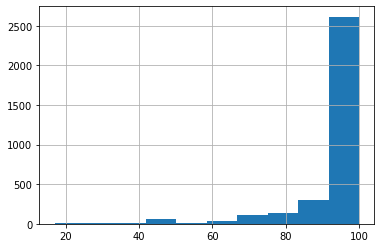

In [47]:
temp.hist();

In [48]:
# Fill the NA with lower quartile value
listings['host_response_rate'] = listings['host_response_rate'].fillna('98%')

In [49]:
# Convert strings to float numbers
listings['host_response_rate'] = listings['host_response_rate'].apply(lambda x: float(x.replace('%','')))

In [50]:
listings['host_response_rate']  = listings['host_response_rate'].apply(lambda x: x/100)

In [51]:
listings['host_response_rate'].head()

0    0.96
1    0.98
2    0.67
3    0.98
4    1.00
Name: host_response_rate, dtype: float64

In [52]:
df_copy = listings.copy()

# Update the data clean log
data_clean_log.at[6,['action','nrow_after','ncol_after']] = ['Recode Percentage features',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0
3,Drop features with low variability,3818.0,65.0
4,Drop text features,3818.0,51.0
5,Recode Price features,3818.0,51.0
6,Recode Percentage features,3818.0,51.0


c) Convert boolean features(T/F) to 1/0

In [53]:
listings.head(2)

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,2011-08-11,within a few hours,0.96,f,Queen Anne,3.0,3.0,t,Queen Anne,West Queen Anne,Queen Anne,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,2,5.0,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,5177328,2013-02-21,within an hour,0.98,t,Queen Anne,6.0,6.0,t,Queen Anne,West Queen Anne,Queen Anne,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,40.0,1,0.0,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48


In [54]:
boolean = ['host_is_superhost','host_identity_verified','is_location_exact','instant_bookable',
           'require_guest_profile_picture','require_guest_phone_verification']

In [55]:
listings[boolean].isnull().sum()

host_is_superhost                   2
host_identity_verified              2
is_location_exact                   0
instant_bookable                    0
require_guest_profile_picture       0
require_guest_phone_verification    0
dtype: int64

In [56]:
listings.host_is_superhost.value_counts()

f    3038
t     778
Name: host_is_superhost, dtype: int64

In [57]:
# Fill the NA in host_is_superhost with f
listings.host_is_superhost.fillna('f');

In [58]:
listings.host_identity_verified.value_counts()

t    2997
f     819
Name: host_identity_verified, dtype: int64

In [59]:
# Although most host verified their identities, we will treat NA value as False in this case
listings.host_identity_verified.fillna('f');

In [60]:
for i in boolean:
  listings[i] = listings[i].apply(lambda x: 1 if x=='t' else 0)

In [61]:
listings[boolean].head()

,host_is_superhost,host_identity_verified,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,0,1,1,0,0,0
1,1,1,1,0,1,1
2,0,1,1,0,0,0
3,0,1,1,0,0,0
4,0,1,1,0,0,0


In [62]:
df_copy = listings.copy()

# Update the data clean log
data_clean_log.at[7,['action','nrow_after','ncol_after']] = ['Recode Boolean features',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0
3,Drop features with low variability,3818.0,65.0
4,Drop text features,3818.0,51.0
5,Recode Price features,3818.0,51.0
6,Recode Percentage features,3818.0,51.0
7,Recode Boolean features,3818.0,51.0


#### **6) Recode the date features**

In [63]:
date = ['host_since','first_review','last_review',]

In [64]:
listings[date].head()

,host_since,first_review,last_review
0,2011-08-11,2011-11-01,2016-01-02
1,2013-02-21,2013-08-19,2015-12-29
2,2014-06-12,2014-07-30,2015-09-03
3,2013-11-06,NaN,NaN
4,2011-11-29,2012-07-10,2015-10-24


In [65]:
listings[date].isnull().sum()

host_since        2
first_review    627
last_review     627
dtype: int64

In [66]:
from datetime import datetime
for i in date:
    listings[i] = pd.to_datetime(listings[i])

In [67]:
# Create a new feature, host_duration, which is data scraped date(2016-01-04) - host_since
listings['host_duration'] = pd.to_datetime('2016-01-04') - listings['host_since']

In [68]:
df_copy = listings.copy()

# Update the data clean log
data_clean_log.at[8,['action','nrow_after','ncol_after']] = ['Recode date features',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0
3,Drop features with low variability,3818.0,65.0
4,Drop text features,3818.0,51.0
5,Recode Price features,3818.0,51.0
6,Recode Percentage features,3818.0,51.0
7,Recode Boolean features,3818.0,51.0
8,Recode date features,3818.0,52.0


#### **7) Convert categorical features to dummy coded variables**

In [69]:
cat = ['host_response_time','property_type','room_type',
       'bed_type','cancellation_policy']

In [70]:
for i in cat:
    print(listings[i].value_counts(dropna = False))

within an hour        1692
within a few hours     968
within a day           597
NaN                    523
a few days or more      38
Name: host_response_time, dtype: int64
House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
NaN                   1
Name: property_type, dtype: int64
Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64
Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64
strict      1417
moderate    1251
flexible    1150
Name: cancellation_policy, dtype: int64


In [71]:
# Classifying the propertie type into 4 main categories, House, Apartment, Townhouse or Condo, Others
def recode_property_type(df):
  if df['property_type'] == 'House': 
    return 'House'
  elif df['property_type'] == 'Apartment':
    return 'Apartment'
  elif df['property_type'] == 'Condominium' or df['property_type'] == 'Townhouse':
    return 'Townhouse or Condo'
  else:
    return 'Others'

listings['property_type'] = listings.apply(recode_property_type, axis=1)
listings.property_type.value_counts()

House                 1733
Apartment             1708
Townhouse or Condo     209
Others                 168
Name: property_type, dtype: int64

In [72]:
# Classifying bed_type into 2 main categories, real_bed, not_real_bed
def recode_bed_type(df):
  if df['bed_type'] == 'Real Bed':
    return 'Real Bed'
  else:
    return 'Not real bed'

listings['bed_type'] = listings.apply(recode_bed_type, axis=1)
listings.bed_type.value_counts()

Real Bed        3657
Not real bed     161
Name: bed_type, dtype: int64

In [73]:
listings.head(2)

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_duration
0,241032,956883,2011-08-11,within a few hours,0.96,0,Queen Anne,3.0,3.0,1,Queen Anne,West Queen Anne,Queen Anne,47.636289,-122.371025,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,2,5.0,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,moderate,0,0,2,4.07,1607 days
1,953595,5177328,2013-02-21,within an hour,0.98,1,Queen Anne,6.0,6.0,1,Queen Anne,West Queen Anne,Queen Anne,47.639123,-122.365666,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,40.0,1,0.0,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict,1,1,6,1.48,1047 days


In [74]:
neighbourhood = ['host_neighbourhood','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']

In [75]:
for i in neighbourhood:
  print(listings[i].value_counts(dropna = False))


Capitol Hill         405
NaN                  300
Belltown             254
Ballard              210
Minor                191
                    ... 
Roxhill                1
Central San Pedro      1
Huntington Beach       1
Waianae Coast          1
Pinehurst              1
Name: host_neighbourhood, Length: 103, dtype: int64
NaN                   416
Capitol Hill          351
Ballard               213
Belltown              204
Minor                 192
                     ... 
South Park              2
South Beacon Hill       2
North College Park      1
Roxhill                 1
Fairmount Park          1
Name: neighbourhood, Length: 82, dtype: int64
Broadway             397
Belltown             234
Wallingford          167
Fremont              158
Minor                135
                    ... 
Arbor Heights          5
South Beacon Hill      4
Pinehurst              4
South Park             3
Roxhill                2
Name: neighbourhood_cleansed, Length: 87, dtype: int64
Other neigh

In [76]:
# There are too many categories in neighbourhood,host_neighbourhood and neighbourhood_cleansed
# So we are going to remove these 3 features
listings.drop(columns=['neighbourhood','host_neighbourhood','neighbourhood_cleansed'],inplace=True);

In [77]:
# Convert categorical features into dummy varibles.
# There 17 categories in neighbourhood_group_cleansed, so we will not recode it at this time.
for i in cat:
    listings = pd.concat([listings, 
                    pd.get_dummies(listings[i], prefix = i, prefix_sep = '_', 
                                drop_first = False, dummy_na = True)], axis=1)

In [78]:
df_copy = listings.copy()

# Update the data clean log
data_clean_log.at[9,['action','nrow_after','ncol_after']] = ['Create dummy variables',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0
3,Drop features with low variability,3818.0,65.0
4,Drop text features,3818.0,51.0
5,Recode Price features,3818.0,51.0
6,Recode Percentage features,3818.0,51.0
7,Recode Boolean features,3818.0,51.0
8,Recode date features,3818.0,52.0
9,Create dummy variables,3818.0,70.0


#### **8) Missing Value**

In [79]:
listings.isnull().mean()[listings.isnull().sum() != 0]

host_since                     0.000524
host_response_time             0.136983
host_listings_count            0.000524
host_total_listings_count      0.000524
bathrooms                      0.004191
bedrooms                       0.001572
beds                           0.000262
first_review                   0.164222
last_review                    0.164222
review_scores_rating           0.169460
review_scores_accuracy         0.172342
review_scores_cleanliness      0.171032
review_scores_checkin          0.172342
review_scores_communication    0.170508
review_scores_location         0.171556
review_scores_value            0.171818
reviews_per_month              0.164222
host_duration                  0.000524
dtype: float64

**Fill the NAN in host_listings_count**

In [80]:
listings[listings.host_listings_count.isnull()]

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_duration,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,property_type_Apartment,property_type_House,property_type_Others,property_type_Townhouse or Condo,property_type_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Not real bed,bed_type_Real Bed,bed_type_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan
1297,8354452,42515980,NaT,NaN,0.98,0,NaN,NaN,0,Downtown,47.616705,-122.353969,1,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",99.0,25.0,1,25.0,2,13,2 months ago,30,60,89,89,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,moderate,0,0,1,NaN,NaT,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1419,10235014,1075031,NaT,NaN,0.98,0,NaN,NaN,0,Downtown,47.615974,-122.340537,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",250.0,0.0,1,0.0,1,1125,a week ago,3,3,3,3,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN,NaT,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0


In [81]:
# Each host_id post only 1 host property, respectively
# Fill the NA in host_listings_count, host_total_listings_count with 1
listings[['host_listings_count','host_total_listings_count']] = listings[['host_listings_count',
                                                                          'host_total_listings_count']].apply(lambda x: x.fillna(1));

In [83]:
listings[['host_listings_count','host_total_listings_count']].isnull().sum()

host_listings_count          0
host_total_listings_count    0
dtype: int64

**Remove the NAN in bedrooms, bathrooms and beds**

In [84]:
listings.dropna(subset=['bathrooms','bedrooms','beds'],how='any',axis=0,inplace = True)

**Remove NAN in host_duration since there's only 2 nan**

In [85]:
listings.host_duration.isnull().sum()

2

In [86]:
listings = listings.dropna(subset=['host_duration'],how='any',axis=0)

**Impute review ratings with the average of each property type in each neighborhood**

In [88]:
cols_with_NAN = listings.isnull().mean()[listings.isnull().sum() != 0].index.to_list()
reviews_col = []
for i in cols_with_NAN:
  if 'review_' in i:
    reviews_col.append(i)
  elif 'review_s' in i:
    reviews_col.append(i)
  else:
    pass
reviews_col

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [89]:
listings[['neighbourhood_group_cleansed','property_type','review_scores_rating','review_scores_accuracy',
          'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
          'review_scores_value']].groupby(['neighbourhood_group_cleansed','property_type']).mean()


review_scores_rating  ...  review_scores_value
neighbourhood_group_cleansed property_type                             ...                     
Ballard                      Apartment                      95.865385  ...             9.615385
                             House                          95.328000  ...             9.544000
                             Others                         95.875000  ...             9.750000
                             Townhouse or Condo             96.250000  ...             9.500000
Beacon Hill                  Apartment                      93.000000  ...             9.380952
...                                                               ...  ...                  ...
University District          Townhouse or Condo             94.250000  ...            10.000000
West Seattle                 Apartment                      96.343750  ...             9.781250
                             House                          96.008696  ...             9.600000
                             Others                         96.333333  ...             9.666667
                             Townhouse or Condo             91.750000  ...             9.625000

[65 rows x 7 columns]

In [90]:
for i in reviews_col:
  listings[i] = listings.groupby(['neighbourhood_group_cleansed','property_type'])[i].apply(lambda x: x.fillna(x.mean()))

In [91]:
listings.isnull().mean()[listings.isnull().sum() != 0]

host_response_time             0.136795
first_review                   0.163679
last_review                    0.163679
review_scores_rating           0.000527
review_scores_accuracy         0.000527
review_scores_cleanliness      0.000527
review_scores_checkin          0.000527
review_scores_communication    0.000527
review_scores_location         0.000527
review_scores_value            0.000527
reviews_per_month              0.163679
dtype: float64

In [92]:
# Impute the rest na with average of neibourhood
for i in reviews_col:
  listings[i] = listings.groupby(['neighbourhood_group_cleansed'])[i].apply(lambda x: x.fillna(x.mean()))

In [93]:
listings.isnull().mean()[listings.isnull().sum() != 0]

host_response_time    0.136795
first_review          0.163679
last_review           0.163679
reviews_per_month     0.163679
dtype: float64

In [94]:
df_copy = listings.copy()

# Update the data clean log
data_clean_log.at[10,['action','nrow_after','ncol_after']] = ['Dealing with some missing value',
                                                             listings.shape[0],
                                                             listings.shape[1]]
data_clean_log

,action,nrow_after,ncol_after
0,Start,3818.0,92.0
1,Remove unrelated features,3818.0,81.0
2,Drop features with more than 40% of NAN,3818.0,75.0
3,Drop features with low variability,3818.0,65.0
4,Drop text features,3818.0,51.0
5,Recode Price features,3818.0,51.0
6,Recode Percentage features,3818.0,51.0
7,Recode Boolean features,3818.0,51.0
8,Recode date features,3818.0,52.0
9,Create dummy variables,3818.0,70.0


In [95]:
# Save the cleaned dataframe
listings.to_csv('cleaned_list.csv')